# Consigna NX - Challenge.

Cada una de las filas del archivo (indexada por SK_ID_CURR) corresponde a una persona distinta que nos pidió un préstamo, y la columna "TARGET" dice qué ocurrió con ese pedido en particular (es decir, tiene un 1 si su pago se atrasó , es decir, que entraron en default, y 0 si no lo hizo). La idea es que puedas hacer un proceso que permita predecir los clientes futuros que van a entrar en default sobre el préstamo.
El archivo "HomeCredit_columns_description - HomeCredit_columns_description.parquet" tiene la información disponible sobre cada una de las columnas de los otros archivos adjuntos. 

Para poder orientarte nuestra evaluación, vamos a hacer foco en el EDA y en el modelo predictivo, sin entrar en profundidad si la métrica esta tuneada o no.

# EDA para application_train.parquet

In [2]:
%reset -f

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns

In [85]:
def cast_label(categories, data_frame):
    """ Cast labels into categories based on certain strings.
     
    Parameters
    ----------
    categories : dict
        Dict with the categories as keys and labels as values.
    data_frame : pandas DataFrame
        Pandas dataframe with a column that contains the labels to categorize.
    
    Returns:
    ---------
    data_frame : Pandas DataFrame
        Pandas DataFrame with the new categories.  
    """
    
    for key in categories.keys():
        for value in categories[key]:
            data_frame[data_frame.columns[0]] = data_frame[data_frame.columns[0]].map(lambda x: key.lower() if value.lower() in x.lower() else x.lower())

    return data_frame


In [4]:
df = pd.read_parquet('/Users/santiagogimenez/Desktop/NX - Challenge/drive-download-20221102T125102Z-001/Copia de application_train.parquet', engine='pyarrow')
df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Tamaño del dataset
df.shape

(307511, 122)

Tengo tres tipos de datos en nuestro dataset. Objetos, flotantes y enteros. Tengo que discernir si es necesario convertir alguna de las columnas a otro tipo de datos.

In [6]:
#conteo de cada tipo de dato
pd.value_counts(df.dtypes)

float64    65
int64      41
object     16
dtype: int64

## Estructura de datos

### Estructura de datos no-numericos 

In [7]:
df.select_dtypes(exclude='number').head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,None,None,None,None
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,None,None,None,None
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,None,None,None,None


las columnas ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE'] son candidatos para hacerle una conversión a binario. Es mejor tener unificado a todas las variables que sean consideradas como FLAGS.
La variable 'WEEK_APPR_PROCESS_START', al representar el día de la semana, se puede codificar como una variable ordinal.
No se puede decir lo mismo del resto de varibles. Es posible que se deda hacer un onehotencoding.

In [8]:
df.describe(exclude='number').T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


In [76]:
#df[cat_columns].value_counts().plot(kind='bar', subplots=True, layout=(-1,4), figsize=(10,10))

### Estructura de datos numericos 

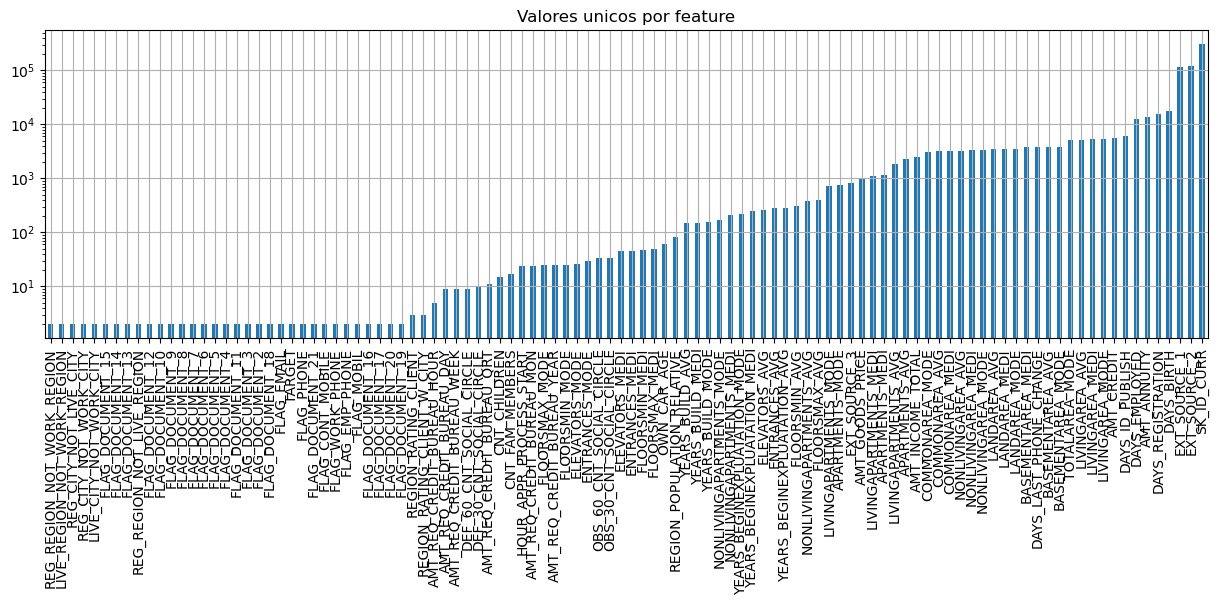

In [9]:
# Por cada feature numerico cuento la cantidad de entradas unicas

unique_values = df.select_dtypes(include="number").nunique().sort_values()

# Ploteo la informacion con el eje-y en escala log para ver los ordenes de magnitud

unique_values.plot.bar(logy=True, figsize=(15, 4), title="Valores unicos por feature")
plt.grid()
plt.show()

## Calidad de datos

### Duplicados

In [10]:
# Veo la cantidad de duplicados que tengo en el index feature

n_duplicates = df.drop(labels=["SK_ID_CURR"], axis=1).duplicated().sum()
print(f"Tenes {n_duplicates} duplicados en tu dataset.")

Tenes 0 duplicados en tu dataset.


No se encontraron filas duplicadas.

### Valores nulos

Text(0, 0.5, 'Sample Number')

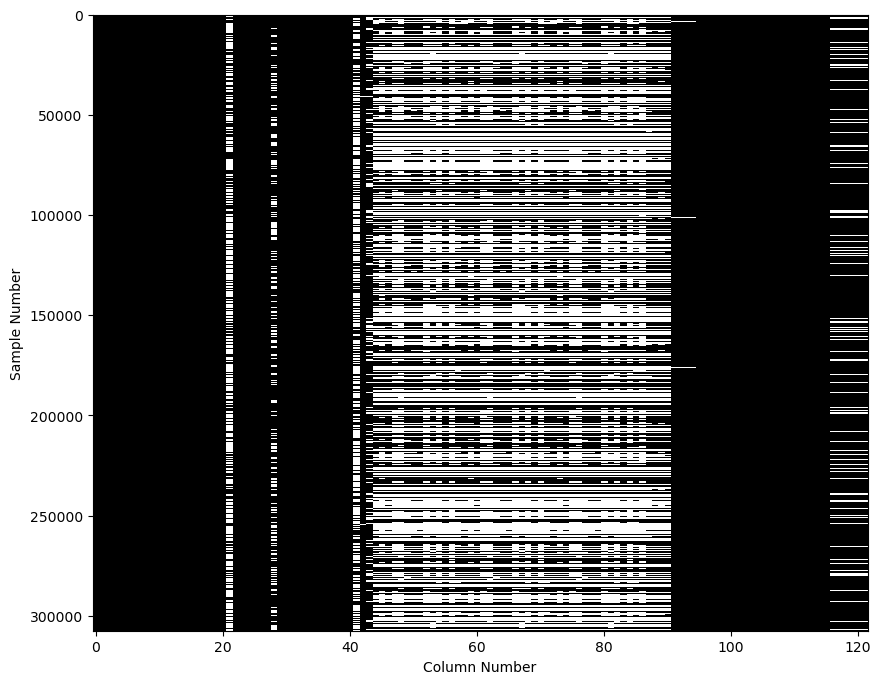

In [11]:
# Aproximacion visual de datos faltantes/nulos

plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

Se puede ver que tengo un gran faltante de datos en entre las columnas 40 y 90.

In [12]:
# Cantidad y porcentaje de valores nulos en las columnas "categoricas"

print('cantidad de valores nulos en variables categoricas')
cat_nan = pd.concat([pd.DataFrame(df.select_dtypes(exclude='number').isna().sum(), columns=['q_nan']),pd.DataFrame(df.select_dtypes(exclude='number').isna().sum()/len(df.select_dtypes(exclude='number'))*100, columns=['perc_nan'])], axis=1)
print(cat_nan.to_markdown())

cantidad de valores nulos en variables categoricas
|                            |   q_nan |   perc_nan |
|:---------------------------|--------:|-----------:|
| NAME_CONTRACT_TYPE         |       0 |   0        |
| CODE_GENDER                |       0 |   0        |
| FLAG_OWN_CAR               |       0 |   0        |
| FLAG_OWN_REALTY            |       0 |   0        |
| NAME_TYPE_SUITE            |    1292 |   0.420148 |
| NAME_INCOME_TYPE           |       0 |   0        |
| NAME_EDUCATION_TYPE        |       0 |   0        |
| NAME_FAMILY_STATUS         |       0 |   0        |
| NAME_HOUSING_TYPE          |       0 |   0        |
| OCCUPATION_TYPE            |   96391 |  31.3455   |
| WEEKDAY_APPR_PROCESS_START |       0 |   0        |
| ORGANIZATION_TYPE          |       0 |   0        |
| FONDKAPREMONT_MODE         |  210295 |  68.3862   |
| HOUSETYPE_MODE             |  154297 |  50.1761   |
| WALLSMATERIAL_MODE         |  156341 |  50.8408   |
| EMERGENCYSTATE_MODE        | 

In [13]:
# Cantidad y porcentaje de valores nulos en las columnas numericas

print('cantidad de valores nulos en variables numericas')
num_nan = pd.concat([pd.DataFrame(df.select_dtypes(include='number').isna().sum(), columns=['q_nan']),pd.DataFrame(df.select_dtypes(include='number').isna().sum()/len(df.select_dtypes(include='number'))*100, columns=['perc_nan'])], axis=1)
print(num_nan.to_markdown())

cantidad de valores nulos en variables numericas
|                              |   q_nan |     perc_nan |
|:-----------------------------|--------:|-------------:|
| SK_ID_CURR                   |       0 |  0           |
| TARGET                       |       0 |  0           |
| CNT_CHILDREN                 |       0 |  0           |
| AMT_INCOME_TOTAL             |       0 |  0           |
| AMT_CREDIT                   |       0 |  0           |
| AMT_ANNUITY                  |      12 |  0.0039023   |
| AMT_GOODS_PRICE              |     278 |  0.0904033   |
| REGION_POPULATION_RELATIVE   |       0 |  0           |
| DAYS_BIRTH                   |       0 |  0           |
| DAYS_EMPLOYED                |       0 |  0           |
| DAYS_REGISTRATION            |       0 |  0           |
| DAYS_ID_PUBLISH              |       0 |  0           |
| OWN_CAR_AGE                  |  202929 | 65.9908      |
| FLAG_MOBIL                   |       0 |  0           |
| FLAG_EMP_PHONE       

In [14]:
# Columnas que tienen un porcentaje de datos nulos mayor al 20% (criterio de corte)

num_nan_pos = num_nan[num_nan['perc_nan']>=20]
cat_nan_pos = cat_nan[cat_nan['perc_nan']>=20]

Tomo 20% de tolerancia para los datos faltantes. Si es posible, se deberían pedir los datos para poder rellenar los datos faltantes.

In [15]:
# imprimo en pantalla las columnas con gran porcetanje de datos nulos.

print(num_nan_pos.to_markdown())
print(cat_nan_pos.to_markdown())

|                              |   q_nan |   perc_nan |
|:-----------------------------|--------:|-----------:|
| OWN_CAR_AGE                  |  202929 |    65.9908 |
| EXT_SOURCE_1                 |  173378 |    56.3811 |
| APARTMENTS_AVG               |  156061 |    50.7497 |
| BASEMENTAREA_AVG             |  179943 |    58.516  |
| YEARS_BEGINEXPLUATATION_AVG  |  150007 |    48.781  |
| YEARS_BUILD_AVG              |  204488 |    66.4978 |
| COMMONAREA_AVG               |  214865 |    69.8723 |
| ELEVATORS_AVG                |  163891 |    53.296  |
| ENTRANCES_AVG                |  154828 |    50.3488 |
| FLOORSMAX_AVG                |  153020 |    49.7608 |
| FLOORSMIN_AVG                |  208642 |    67.8486 |
| LANDAREA_AVG                 |  182590 |    59.3767 |
| LIVINGAPARTMENTS_AVG         |  210199 |    68.355  |
| LIVINGAREA_AVG               |  154350 |    50.1933 |
| NONLIVINGAPARTMENTS_AVG      |  213514 |    69.433  |
| NONLIVINGAREA_AVG            |  169682 |    55

In [16]:
# lista de columnas a dropear por gran cantidad de valores faltantes (mayor al 20%)

col_to_drop = list(num_nan_pos.index)
col_to_drop.extend(list(cat_nan_pos.index))


Dropeo dichas columnas en este momento para que no estorben al momento de graficar las variables.

In [17]:
df.drop(columns=col_to_drop, inplace=True)
df.reset_index(drop=True)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#separo los nombres de las columnas en los diferentes tipos de dato

numerical_columns = [x for x in df.columns if df[x].dtype != 'object' and df[x].dtype != 'bool']
cat_columns = [x for x in df.columns if x not in numerical_columns]
int_columns = [x for x in numerical_columns if df[x].dtypes != 'float64']
float_columns = [x for x in numerical_columns if x not in int_columns]

print('cat:',len(cat_columns),'int:', len(int_columns),'float:', len(float_columns))

cat: 11 int: 41 float: 20


### variables categoricas

In [19]:
df[cat_columns].describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
WEEKDAY_APPR_PROCESS_START,307511,7,TUESDAY,53901


La gran mayoría posee poca cantidad de valores unicos distintos, por lo que se estima un onehotenconding. 
El featrue ORGANIZATION_TYPE posee 58 valores distintos, se debería ver la distribución de dichos valores.

<AxesSubplot: >

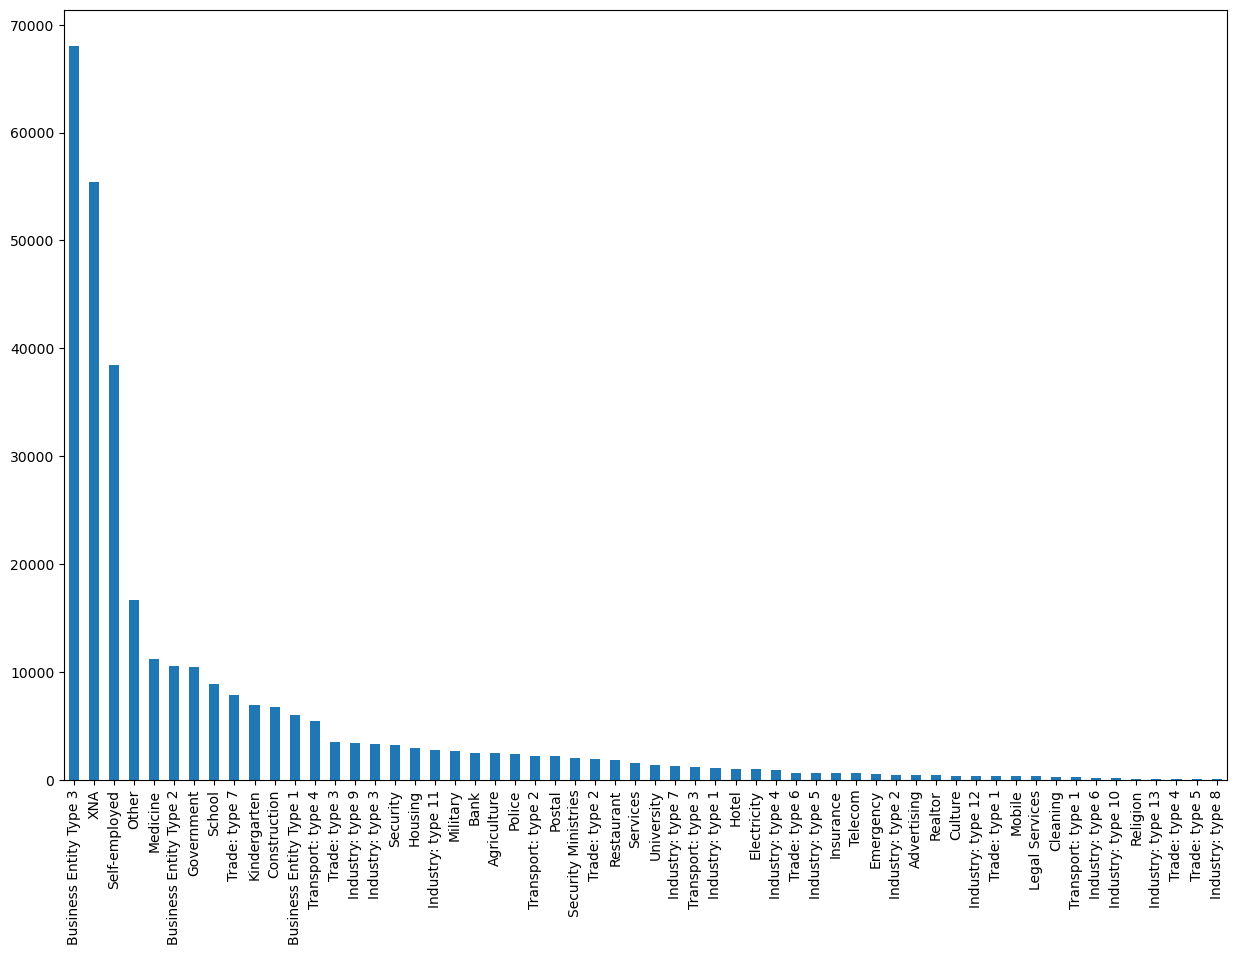

In [20]:
df['ORGANIZATION_TYPE'].value_counts().plot(kind='bar', figsize=(15,10))

In [22]:
dict_categories = {'education': ['school','kindergarten', 'university'],
                'business':['business', 'advertising', 'trade'],
                'transport':['transport'],
                'security':['security','police','military'],
                'industry':['industry'],
                'healthcare':['medicine','emergency','insurance', 'cleaning'],
                'services' : ['telecom','mobile','postal', 'electricity', 'services', 'bank'],
                'turism' : ['hotel','restaurant', 'culture'],
                'real-estate' : ['housing', 'realtor', 'construction'], 
                'other' : ['religion', 'other', 'xna']
                }

data_frame = df[['ORGANIZATION_TYPE']].copy()

cast_label(dict_categories, data_frame)

,ORGANIZATION_TYPE
0,business
1,education
2,government
3,business
4,other
...,...
307506,services
307507,other
307508,education
307509,business


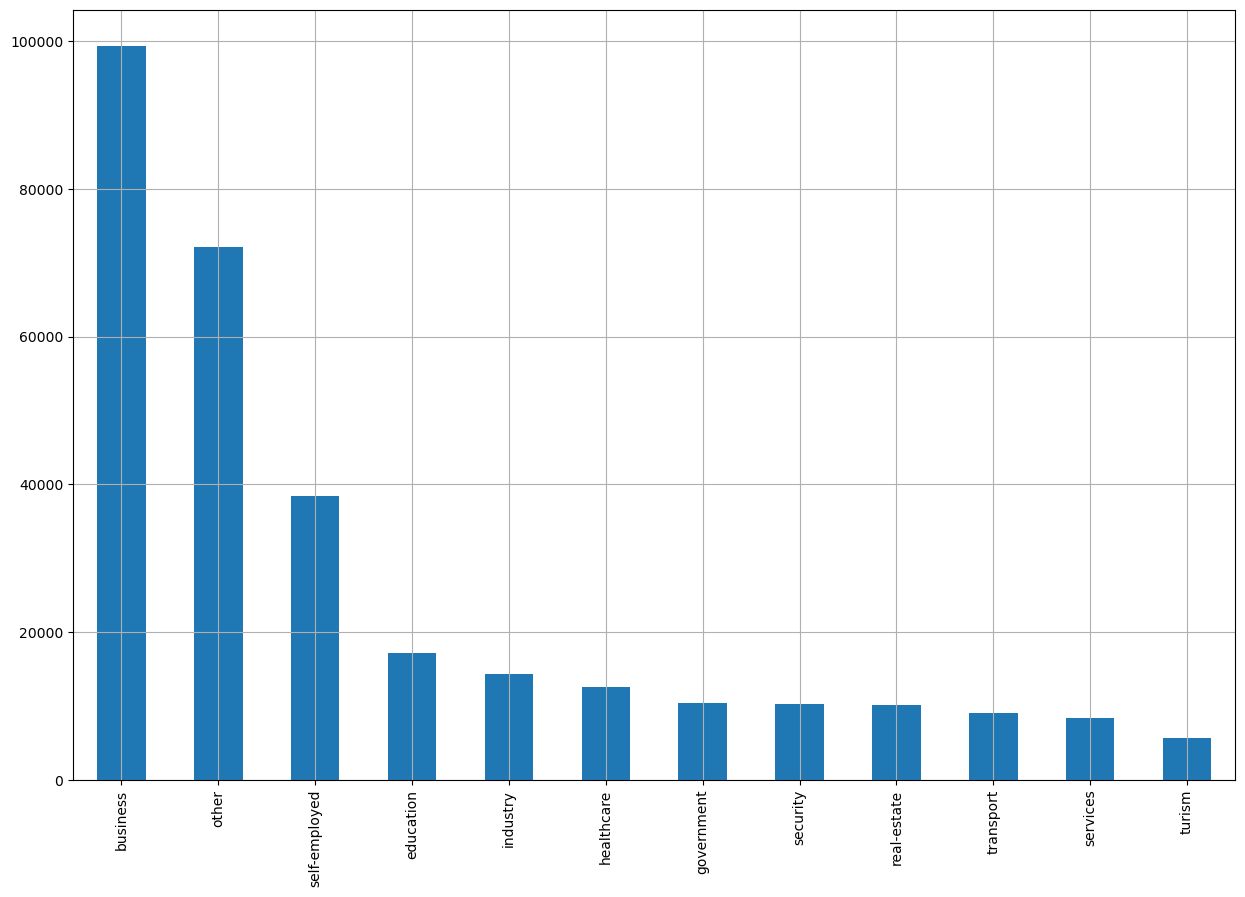

In [23]:
data_frame['ORGANIZATION_TYPE'].value_counts().plot(kind='bar', figsize=(15,10))
plt.grid()

La generacion de categorías se deberían armar en base al objetivo del negocio. Esto es una idea estimativa de como podría llegar a ser.

### Variables numericas

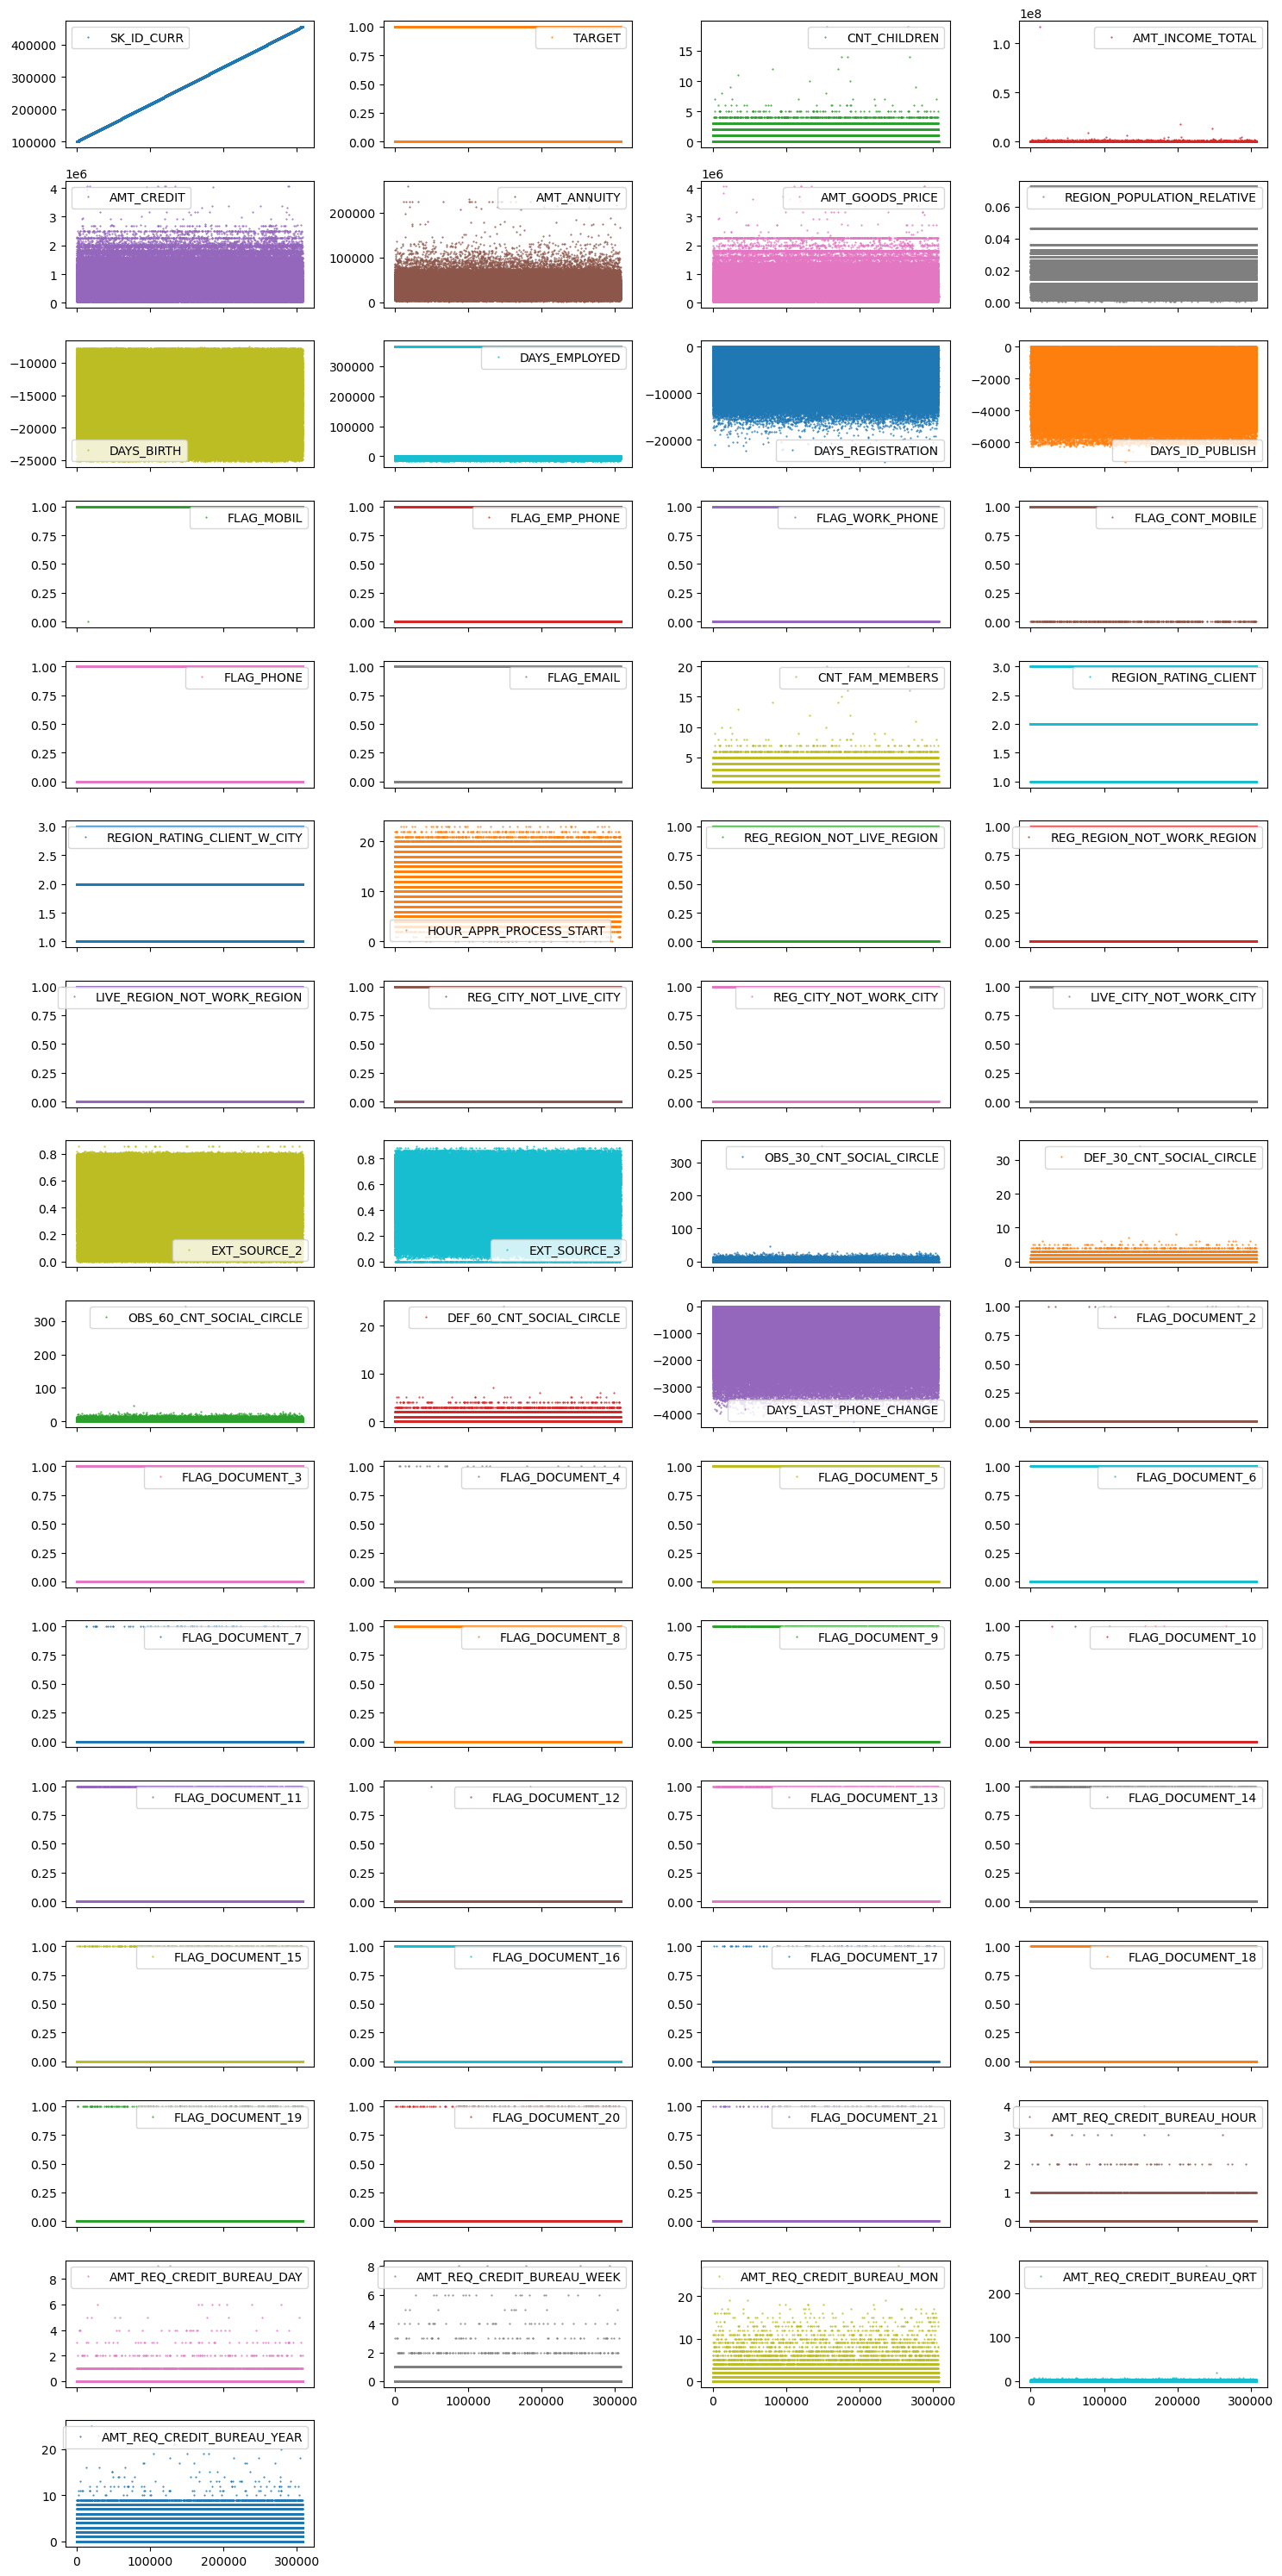

In [24]:
# Me fijo como son los datos en el dataset. esto me ayuda a detectar los datos faltantes.  


df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),figsize=(15, 30), markersize=1)
plt.tight_layout()

#### variables enteras/discretas

In [25]:
df[int_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.0,-19682.0,-15750.0,-12413.0,-7489.0
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.0,-2760.0,-1213.0,-289.0,365243.0
DAYS_ID_PUBLISH,307511.0,-2994.202373,1509.450419,-7197.0,-4299.0,-3254.0,-1720.0,0.0
FLAG_MOBIL,307511.0,0.999997,0.001803,0.0,1.0,1.0,1.0,1.0
FLAG_EMP_PHONE,307511.0,0.819889,0.384280,0.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,307511.0,0.199368,0.399526,0.0,0.0,0.0,0.0,1.0
FLAG_CONT_MOBILE,307511.0,0.998133,0.043164,0.0,1.0,1.0,1.0,1.0


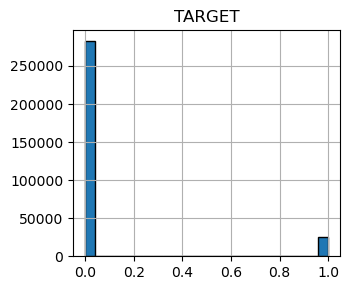

In [26]:
df[['TARGET']].hist(bins=25, figsize=(15, 3), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

In [27]:
df['TARGET'].mean()*100

# Claramente es un dataset desbalanceado, se necesitaria hacer smotes o algún método que nos ayude a balancearlo.

8.072881945686495

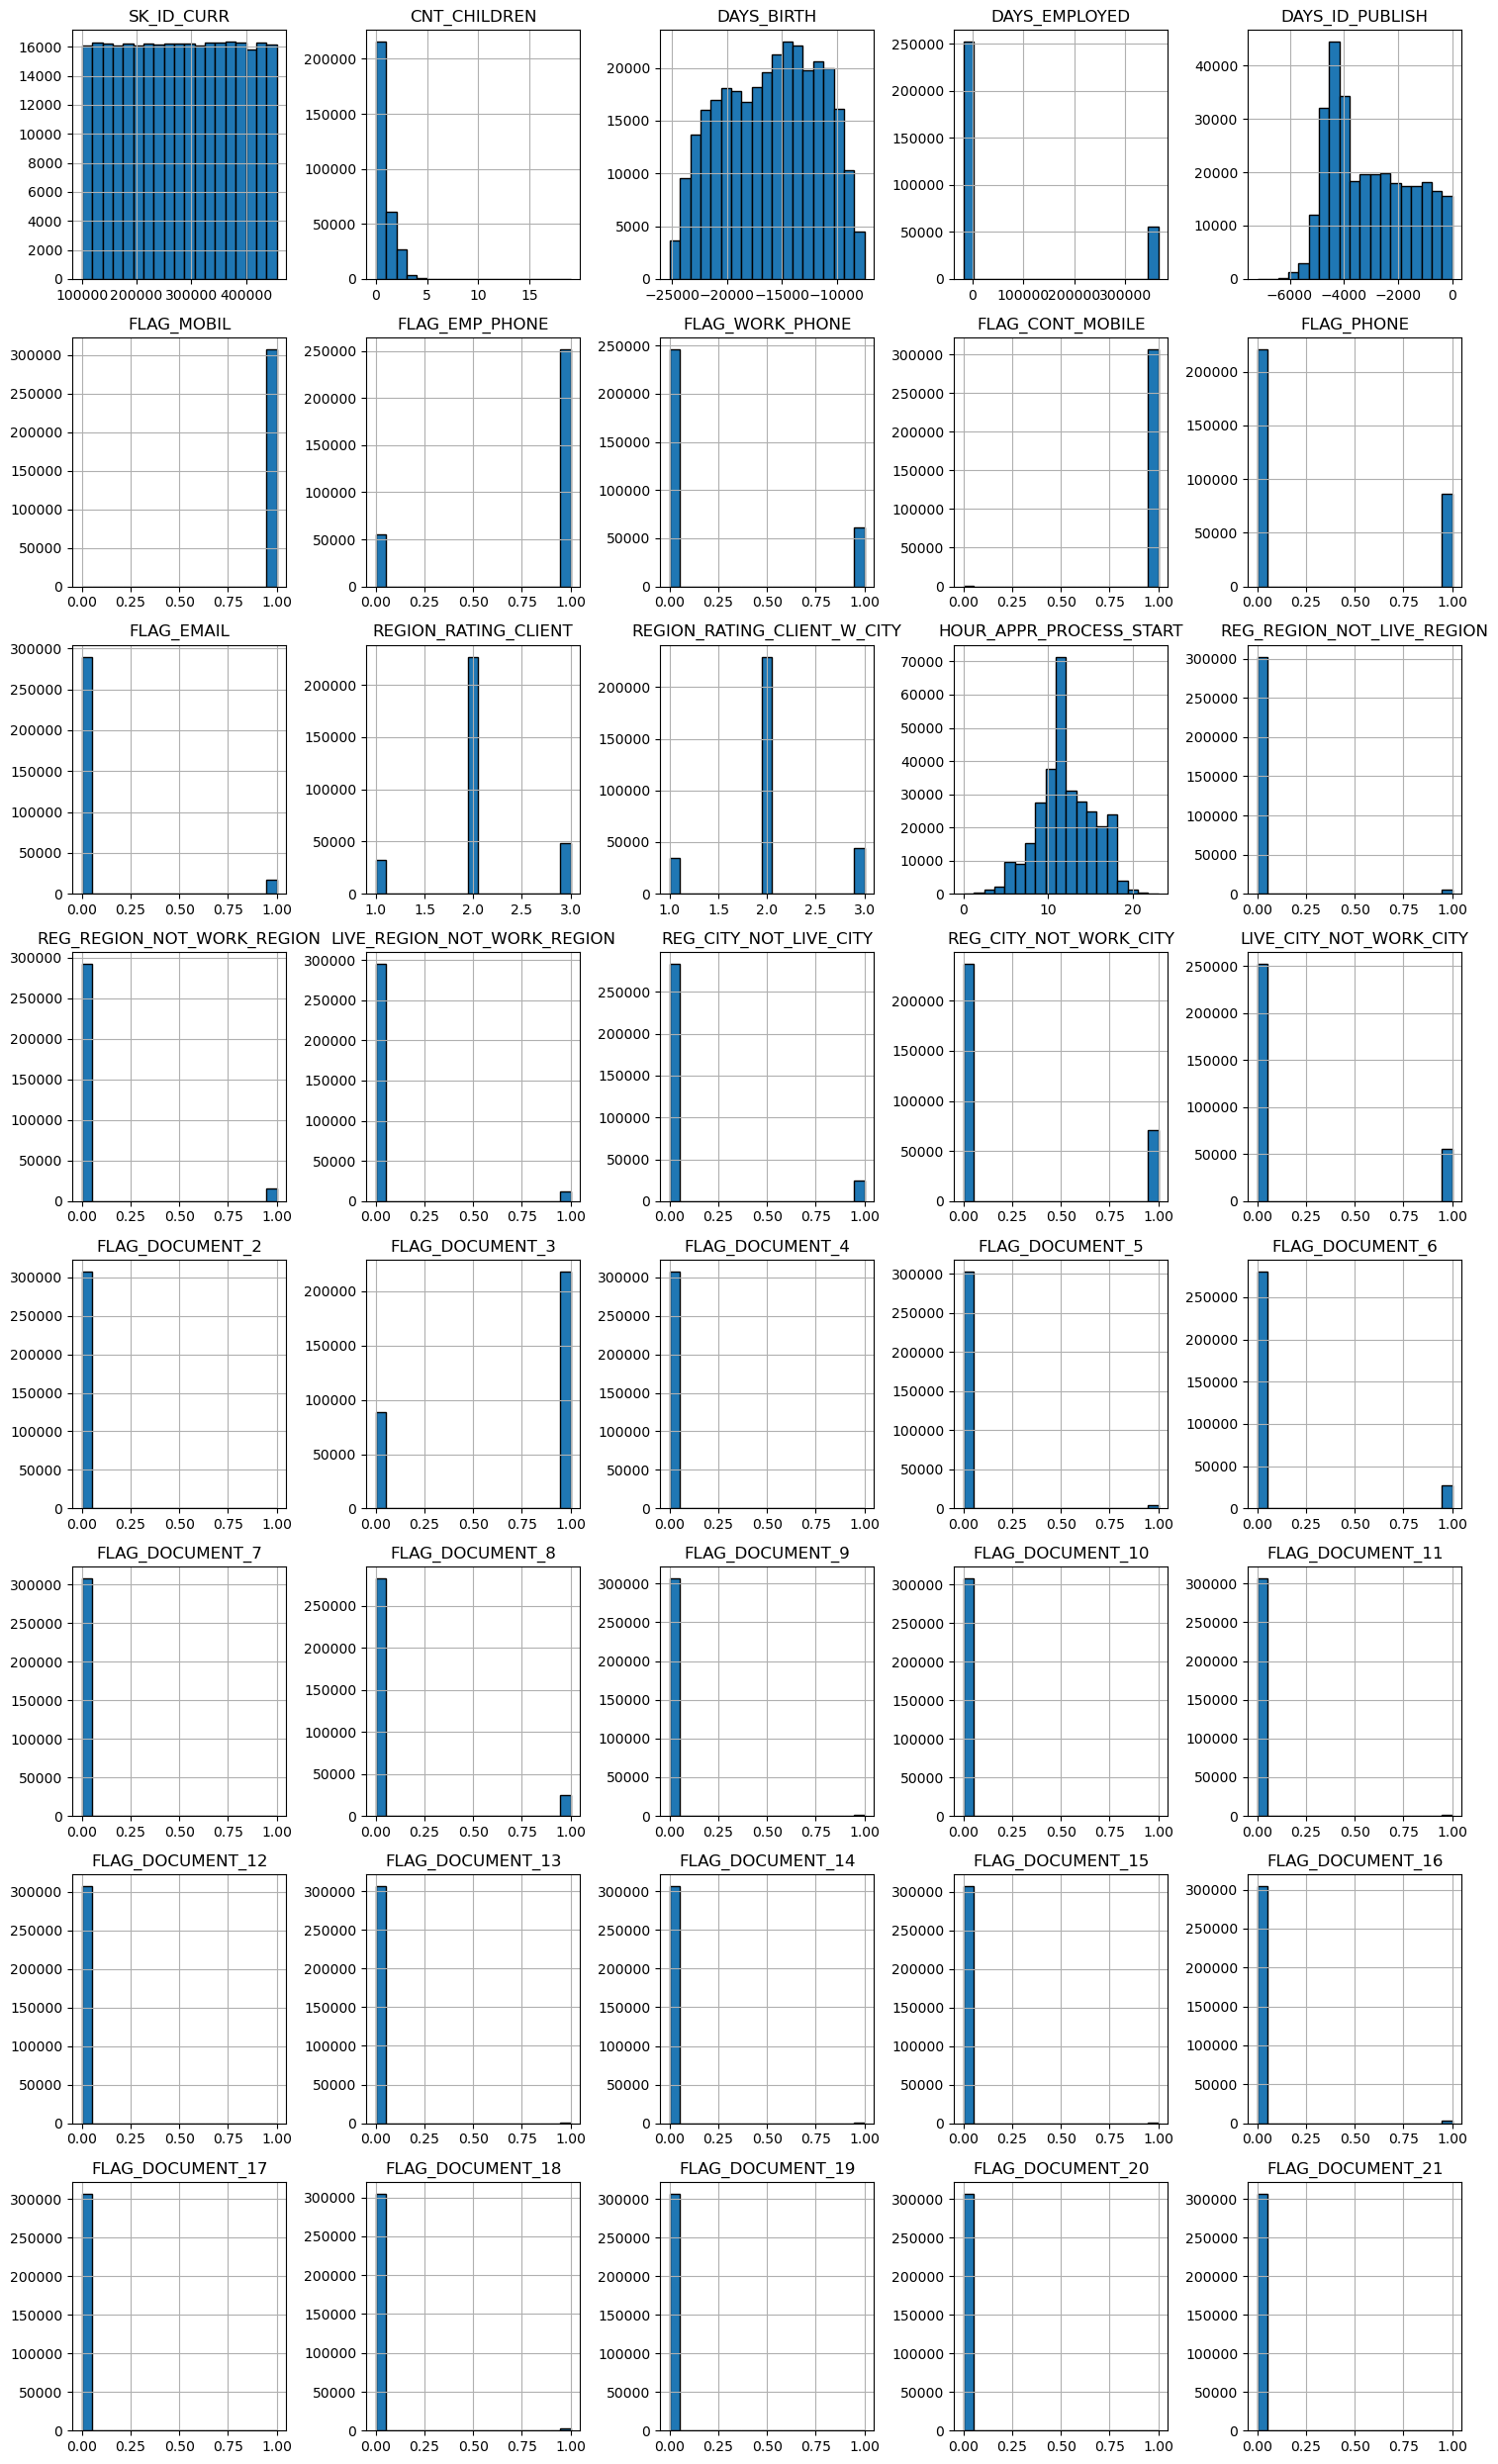

In [28]:
# cantidad de bins que debería tener mi histograma. Utilizo el criterio de Sturge.

n_bins = round(1 + 3.322 * np.log10(len(df)))
n_bins

# Ploteo histogramas de las variables dtype=int64

df[[x for x in int_columns if x != 'TARGET']].hist(bins=n_bins, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

#### variables continuas

In [29]:
df[float_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_REGISTRATION,307511.0,-4986.120328,3522.886321,-2.467200e+04,-7479.500000,-4504.000000,-2010.000000,0.000000e+00
CNT_FAM_MEMBERS,307509.0,2.152665,0.910682,1.000000e+00,2.000000,2.000000,3.000000,2.000000e+01
EXT_SOURCE_2,306851.0,0.514393,0.191060,8.173617e-08,0.392457,0.565961,0.663617,8.549997e-01
EXT_SOURCE_3,246546.0,0.510853,0.194844,5.272652e-04,0.370650,0.535276,0.669057,8.960095e-01
OBS_30_CNT_SOCIAL_CIRCLE,306490.0,1.422245,2.400989,0.000000e+00,0.000000,0.000000,2.000000,3.480000e+02


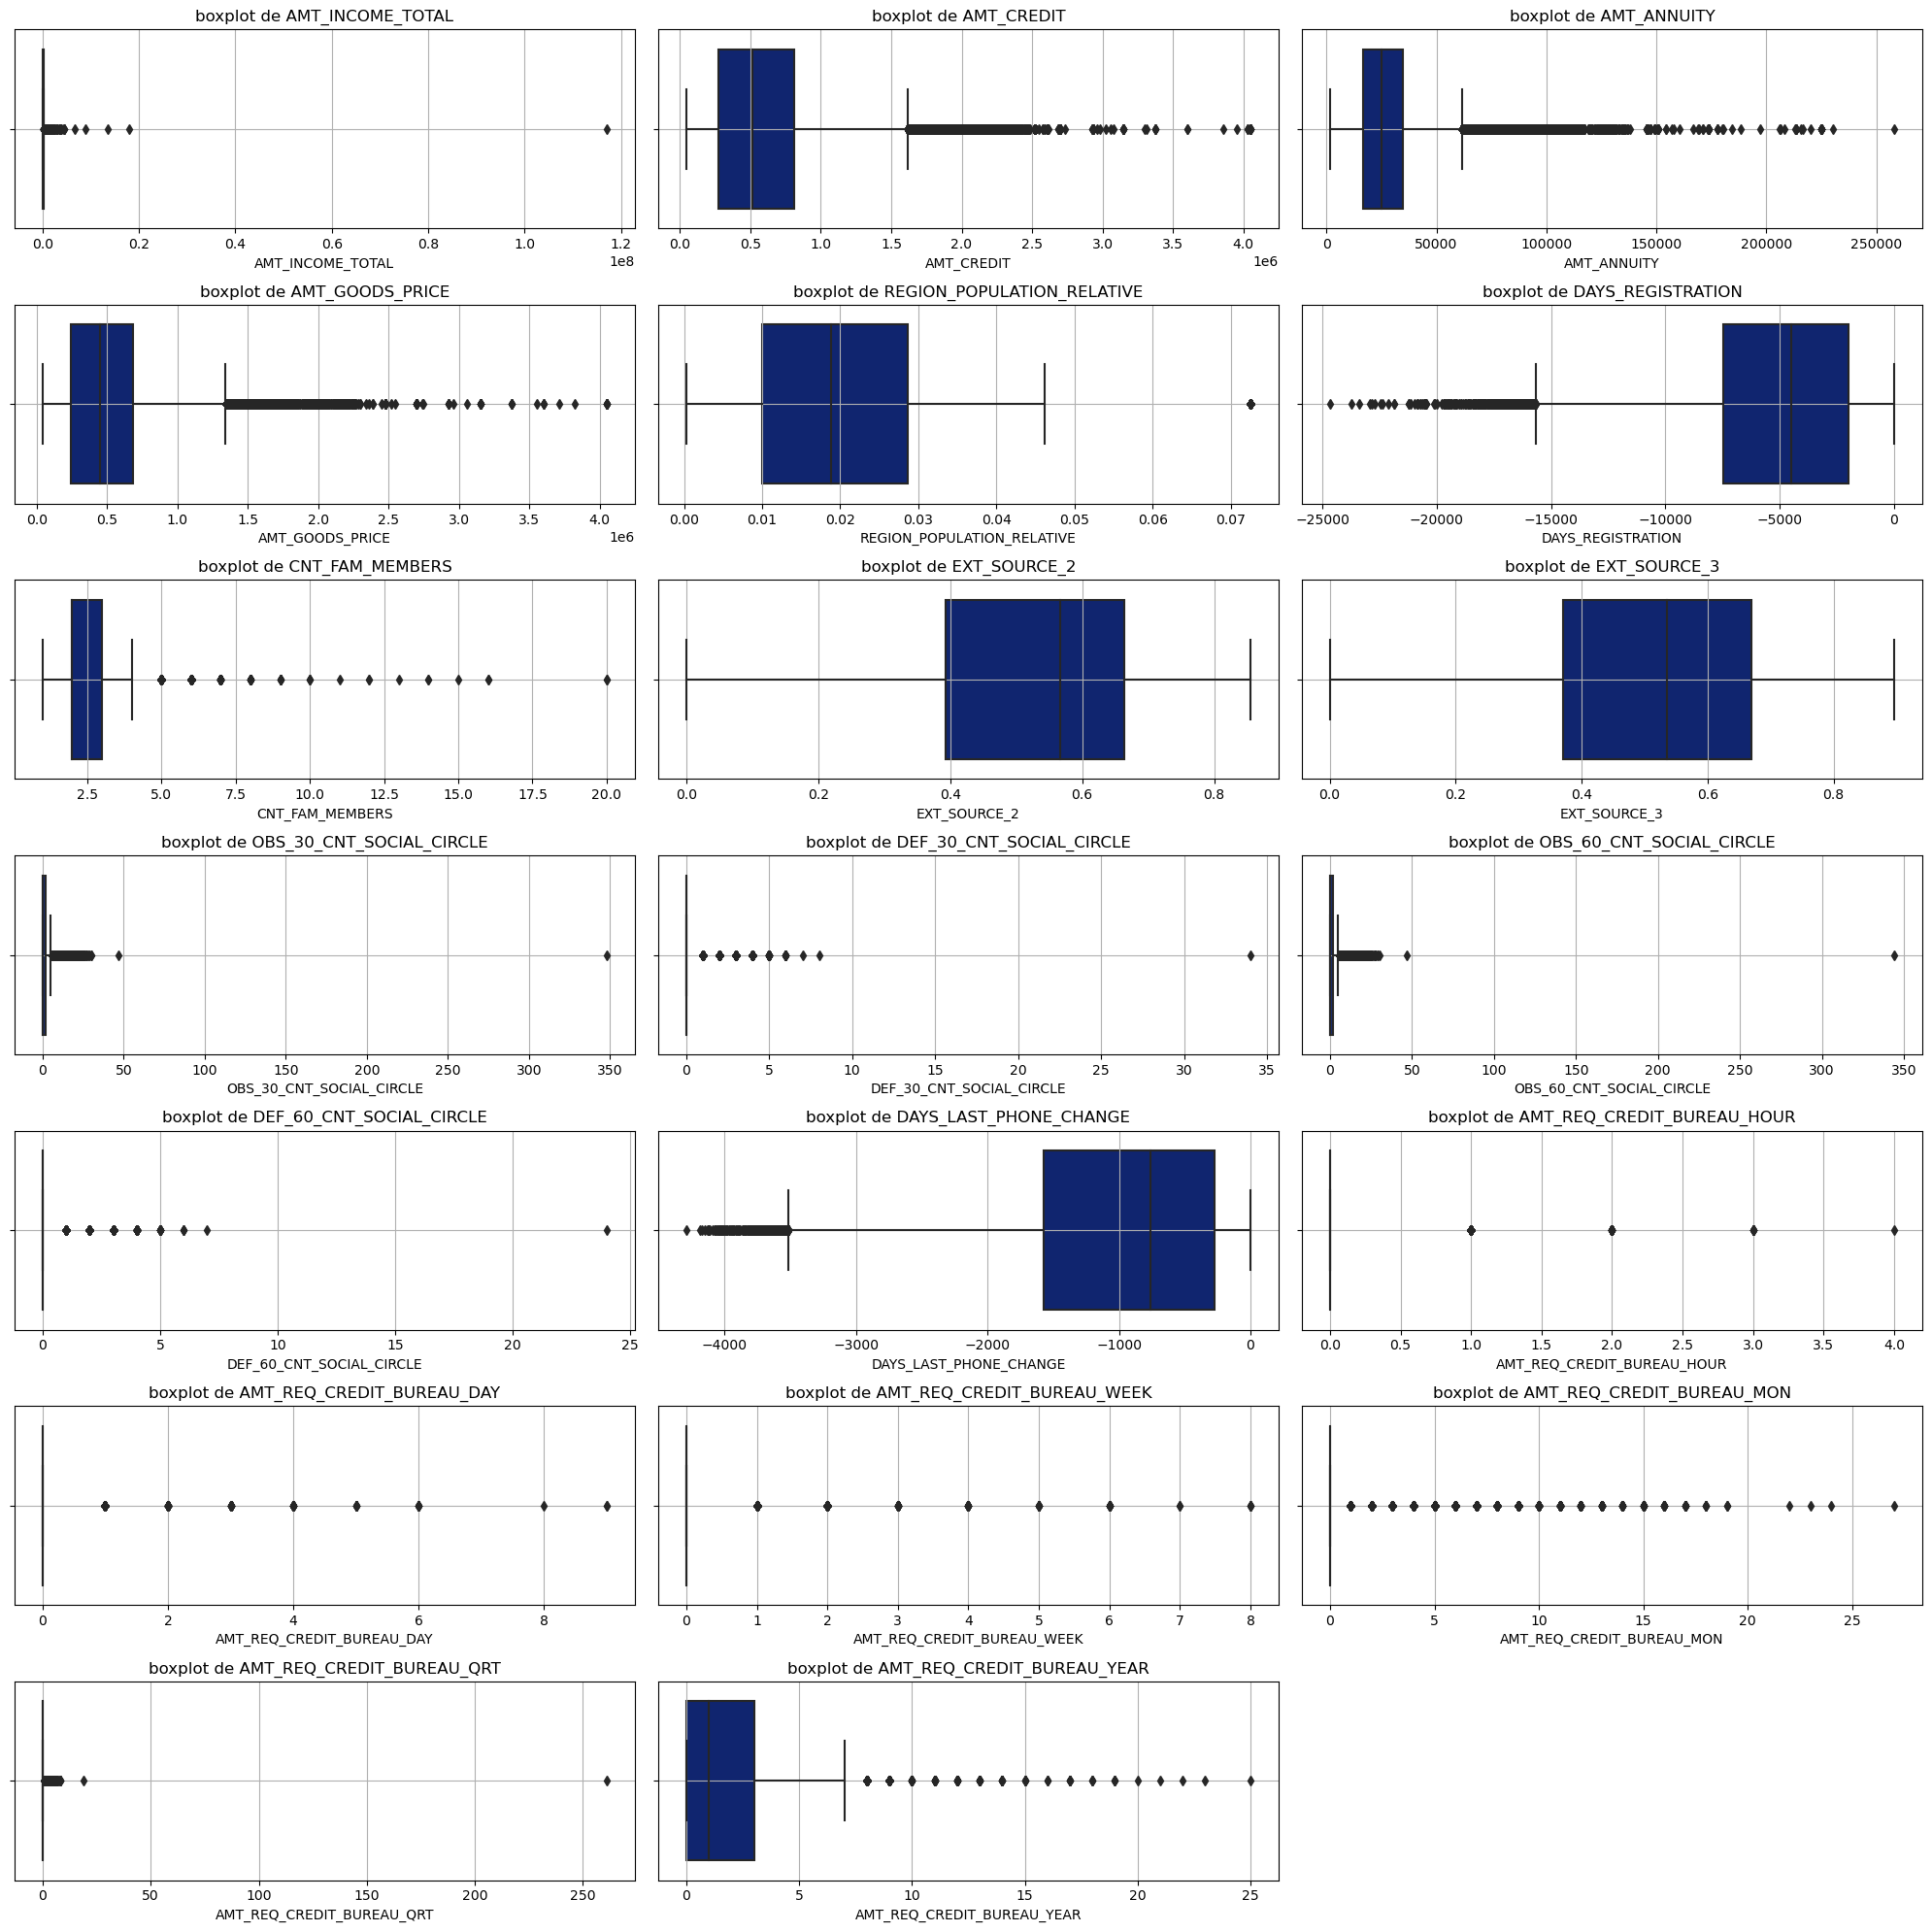

In [30]:
# veo las distribuciones de las varaibles con dtype=float64

plt.figure(figsize=(20,20))
for index, column in enumerate([x for x in float_columns]):
  plt.subplot(ceil(len(float_columns)/3), 3, index+1)
  sns.boxplot(data=df, x=df[column], palette='dark')
  plt.title('boxplot de {}'.format(column))
  plt.grid()  
  plt.tight_layout()

/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagogimenez/miniconda3/envs/nx-challenge/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p


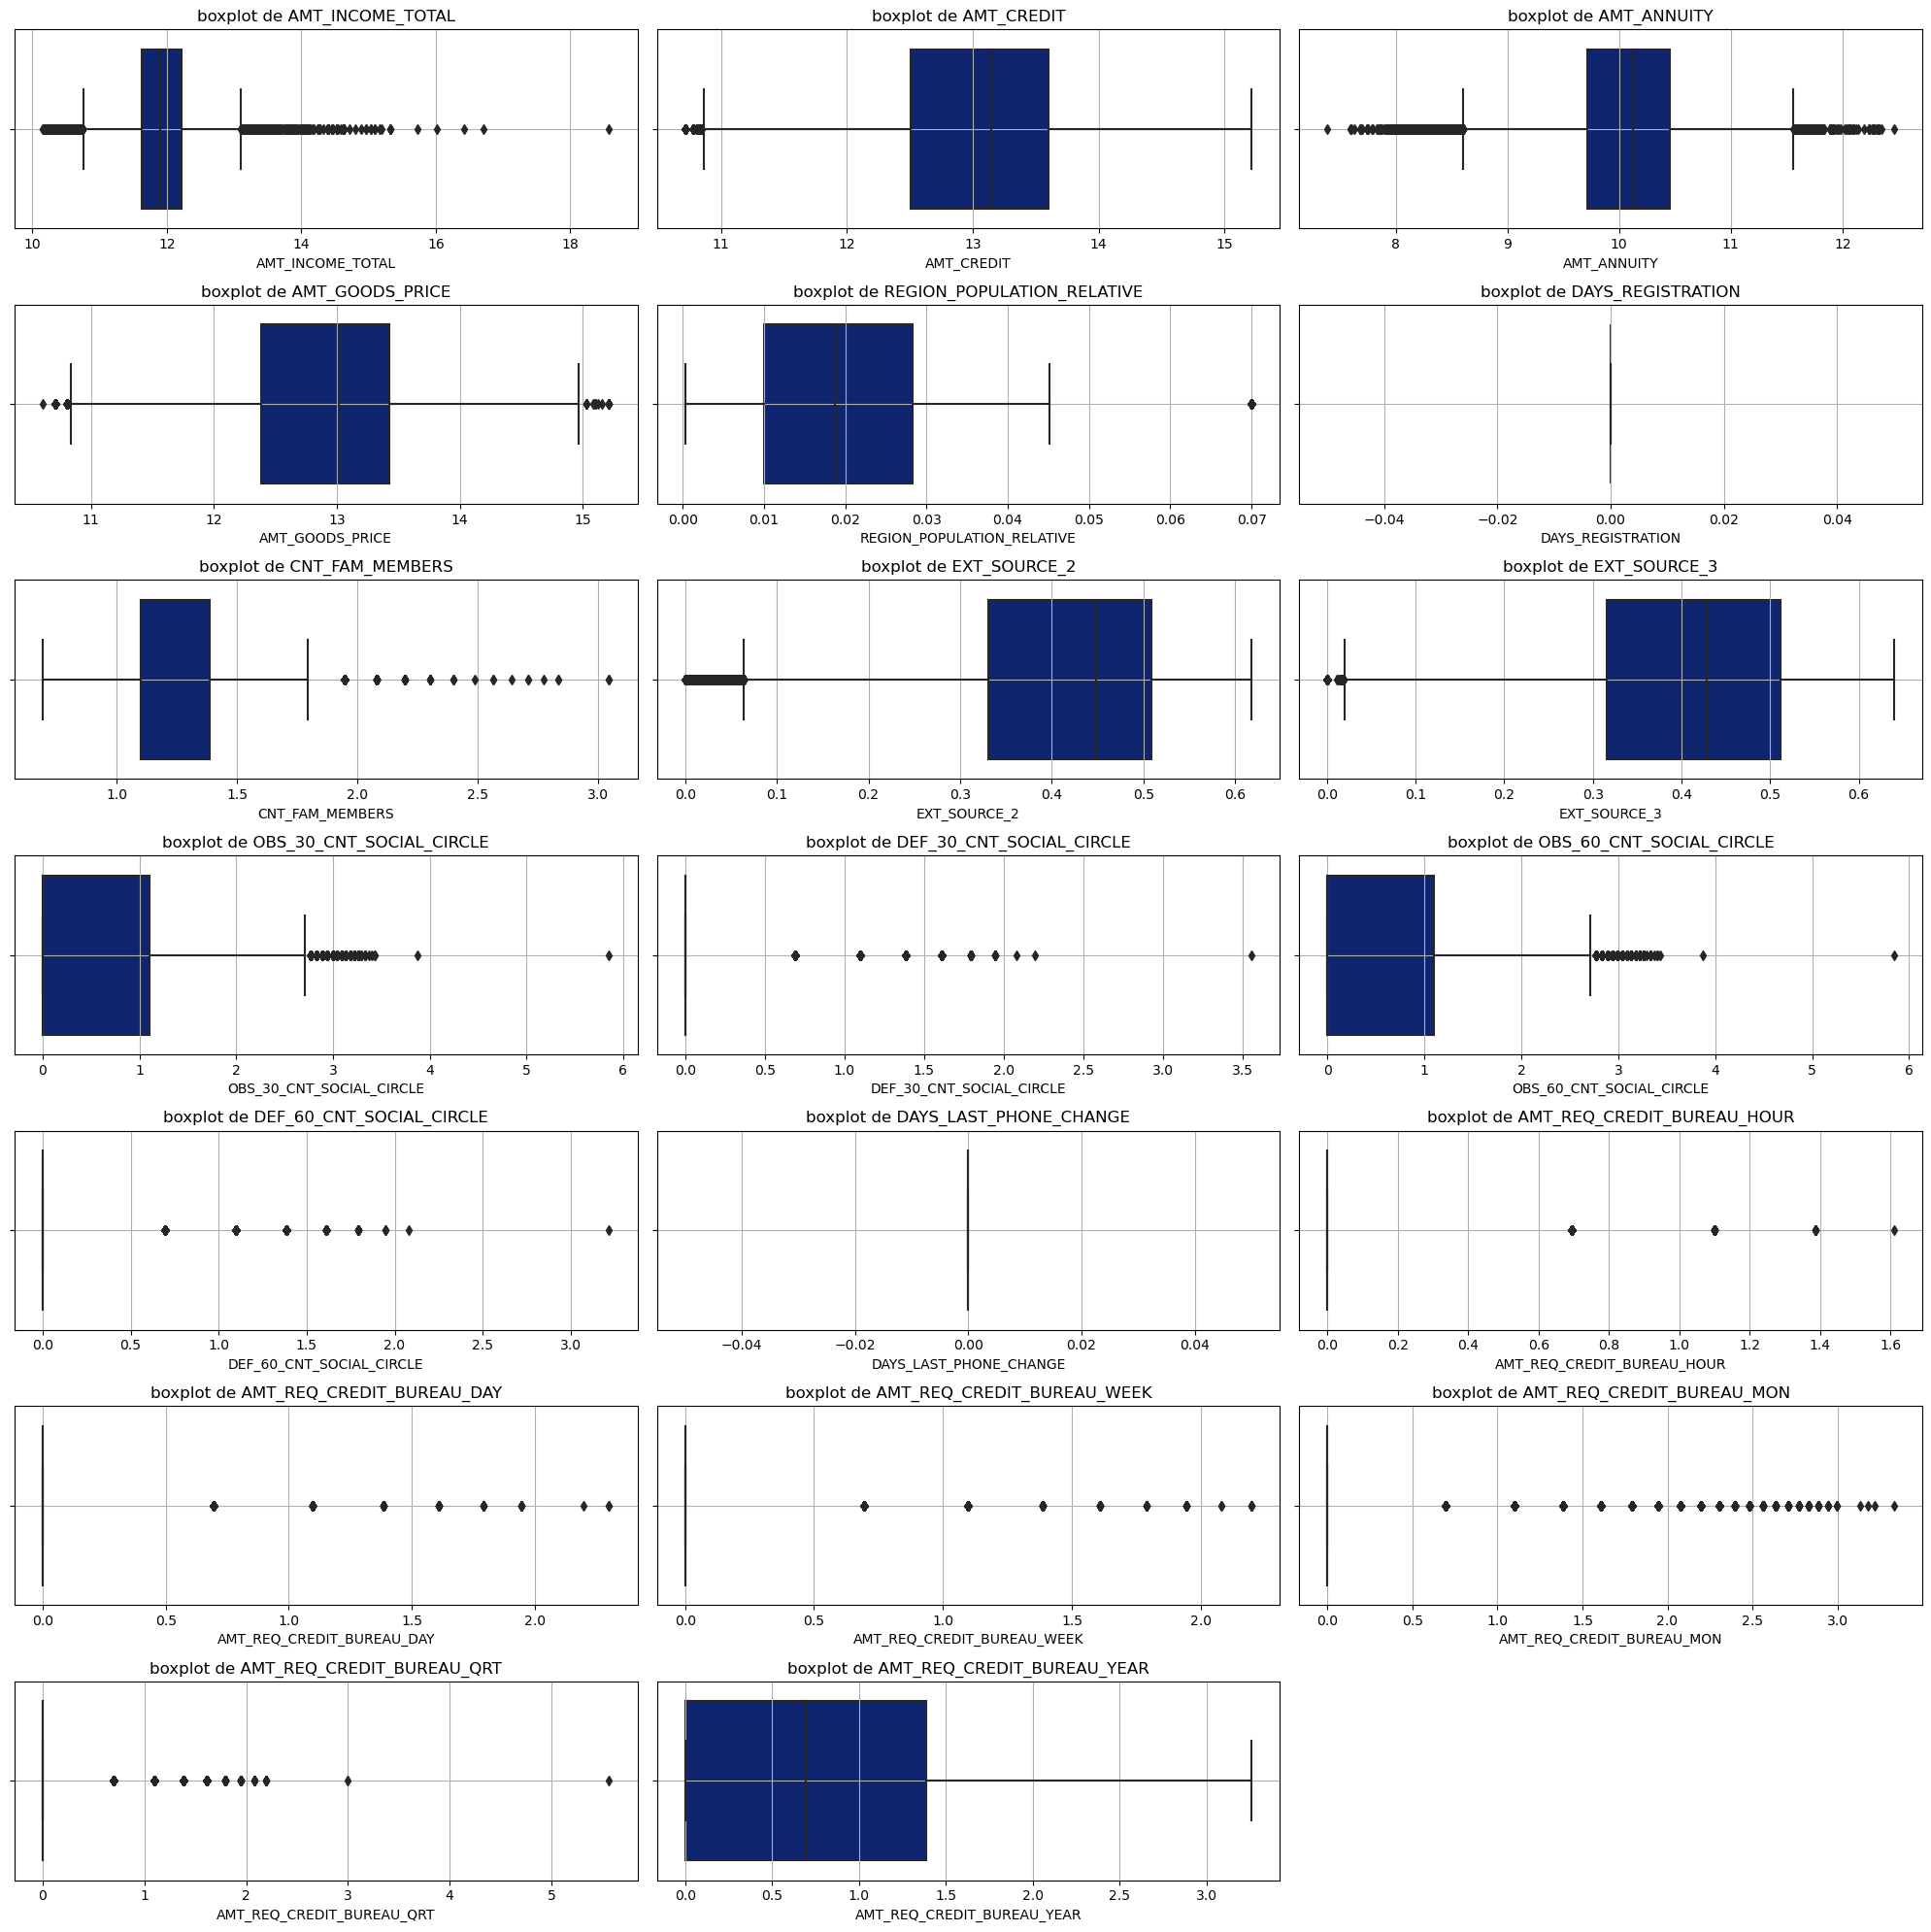

In [31]:

plt.figure(figsize=(20,20))
for index, column in enumerate([x for x in float_columns]):
  plt.subplot(ceil(len(float_columns)/3), 3, index+1)
  sns.boxplot(data=df, x=np.log1p(df[column]), palette='dark')
  plt.title('boxplot de {}'.format(column))
  plt.grid()  
  plt.tight_layout()

Tengo valores de outliers que son sospechosos. por ejemplo CANT_FAMILY_MEMBERS > 10. Es sospechoso, debería hacer foco allí.  
También en DEF_60_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_30_CNT_SOCIAL_CIRCLE  tienen valores extraños.


In [32]:
# me armo el percentil 99% para las diferentes variables que parecen tener outliers.

outliers_detection = ['DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_QRT','CNT_FAM_MEMBERS','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE' ]
outlier_treshold = pd.DataFrame(df.describe(percentiles=[0.99]).loc['99%']).T
outlier_treshold[outliers_detection]

,DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_QRT,CNT_FAM_MEMBERS,CNT_CHILDREN,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE
99%,2.0,10.0,2.0,10.0,2.0,5.0,3.0,472500.0,0.072508


In [33]:
# me fijo la cantidad de valores que pasan el treshold del percentil 99.5%. Estos son los cantidatos a ser eliminados.

for outlier in outliers_detection:
    print(outlier,
    ':',
    pd.DataFrame(df[abs(df[outlier]) > abs(outlier_treshold[outlier].loc['99%'])][outlier]).shape[0], 
    '(',
    pd.DataFrame(df[abs(df[outlier]) > abs(outlier_treshold[outlier].loc['99%'])][outlier]).shape[0]/len(df[outlier])*100 ,
    '%)')


DEF_60_CNT_SOCIAL_CIRCLE : 758 ( 0.24649524732448594 %)
OBS_60_CNT_SOCIAL_CIRCLE : 2691 ( 0.8750906471638413 %)
DEF_30_CNT_SOCIAL_CIRCLE : 1515 ( 0.4926653030298103 %)
OBS_30_CNT_SOCIAL_CIRCLE : 2782 ( 0.9046830845075462 %)
AMT_REQ_CREDIT_BUREAU_QRT : 2301 ( 0.7482659156908208 %)
CNT_FAM_MEMBERS : 529 ( 0.17202636653648162 %)
CNT_CHILDREN : 555 ( 0.180481348634683 %)
AMT_INCOME_TOTAL : 3014 ( 0.9801275401530353 %)
REGION_POPULATION_RELATIVE : 0 ( 0.0 %)


In [34]:
# me fijo la relación entre las familias con mas de diez integrantes y la cantidad de hijos e hijas que tienen.

df[(df['CNT_FAM_MEMBERS']>=10)][['CNT_FAM_MEMBERS','CNT_CHILDREN']]

,CNT_FAM_MEMBERS,CNT_CHILDREN
12615,10.0,8
23881,10.0,9
34545,13.0,11
80948,14.0,12
132585,12.0,10
154317,10.0,8
155369,20.0,19
171125,14.0,12
176011,15.0,14
183878,16.0,14


In [35]:
# me fijo la relación entre las variables de cantidad de personas en default en el entorno del cliente. (Después se observa que hay gran correlacion entre OBS_60 y OBS_30)

df[df['OBS_30_CNT_SOCIAL_CIRCLE']>=20][['DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']]

,DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE
1396,1.0,21.0,1.0,22.0
3004,0.0,22.0,0.0,22.0
5281,0.0,20.0,0.0,20.0
7159,0.0,25.0,0.0,25.0
10467,0.0,20.0,1.0,20.0
...,...,...,...,...
296152,0.0,24.0,0.0,24.0
296762,0.0,19.0,0.0,20.0
299614,0.0,20.0,0.0,20.0
302894,0.0,25.0,0.0,25.0


In [36]:
df[df['OBS_60_CNT_SOCIAL_CIRCLE']>=30][['DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']]

,DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE
77497,0.0,47.0,0.0,47.0
148403,24.0,344.0,34.0,348.0
169517,0.0,30.0,0.0,30.0


In [37]:
df[df['AMT_REQ_CREDIT_BUREAU_QRT']>=100][['AMT_REQ_CREDIT_BUREAU_QRT']]

,AMT_REQ_CREDIT_BUREAU_QRT
239474,261.0


Este parece ser un outlier. Porque es el único valor tan alto que existe.

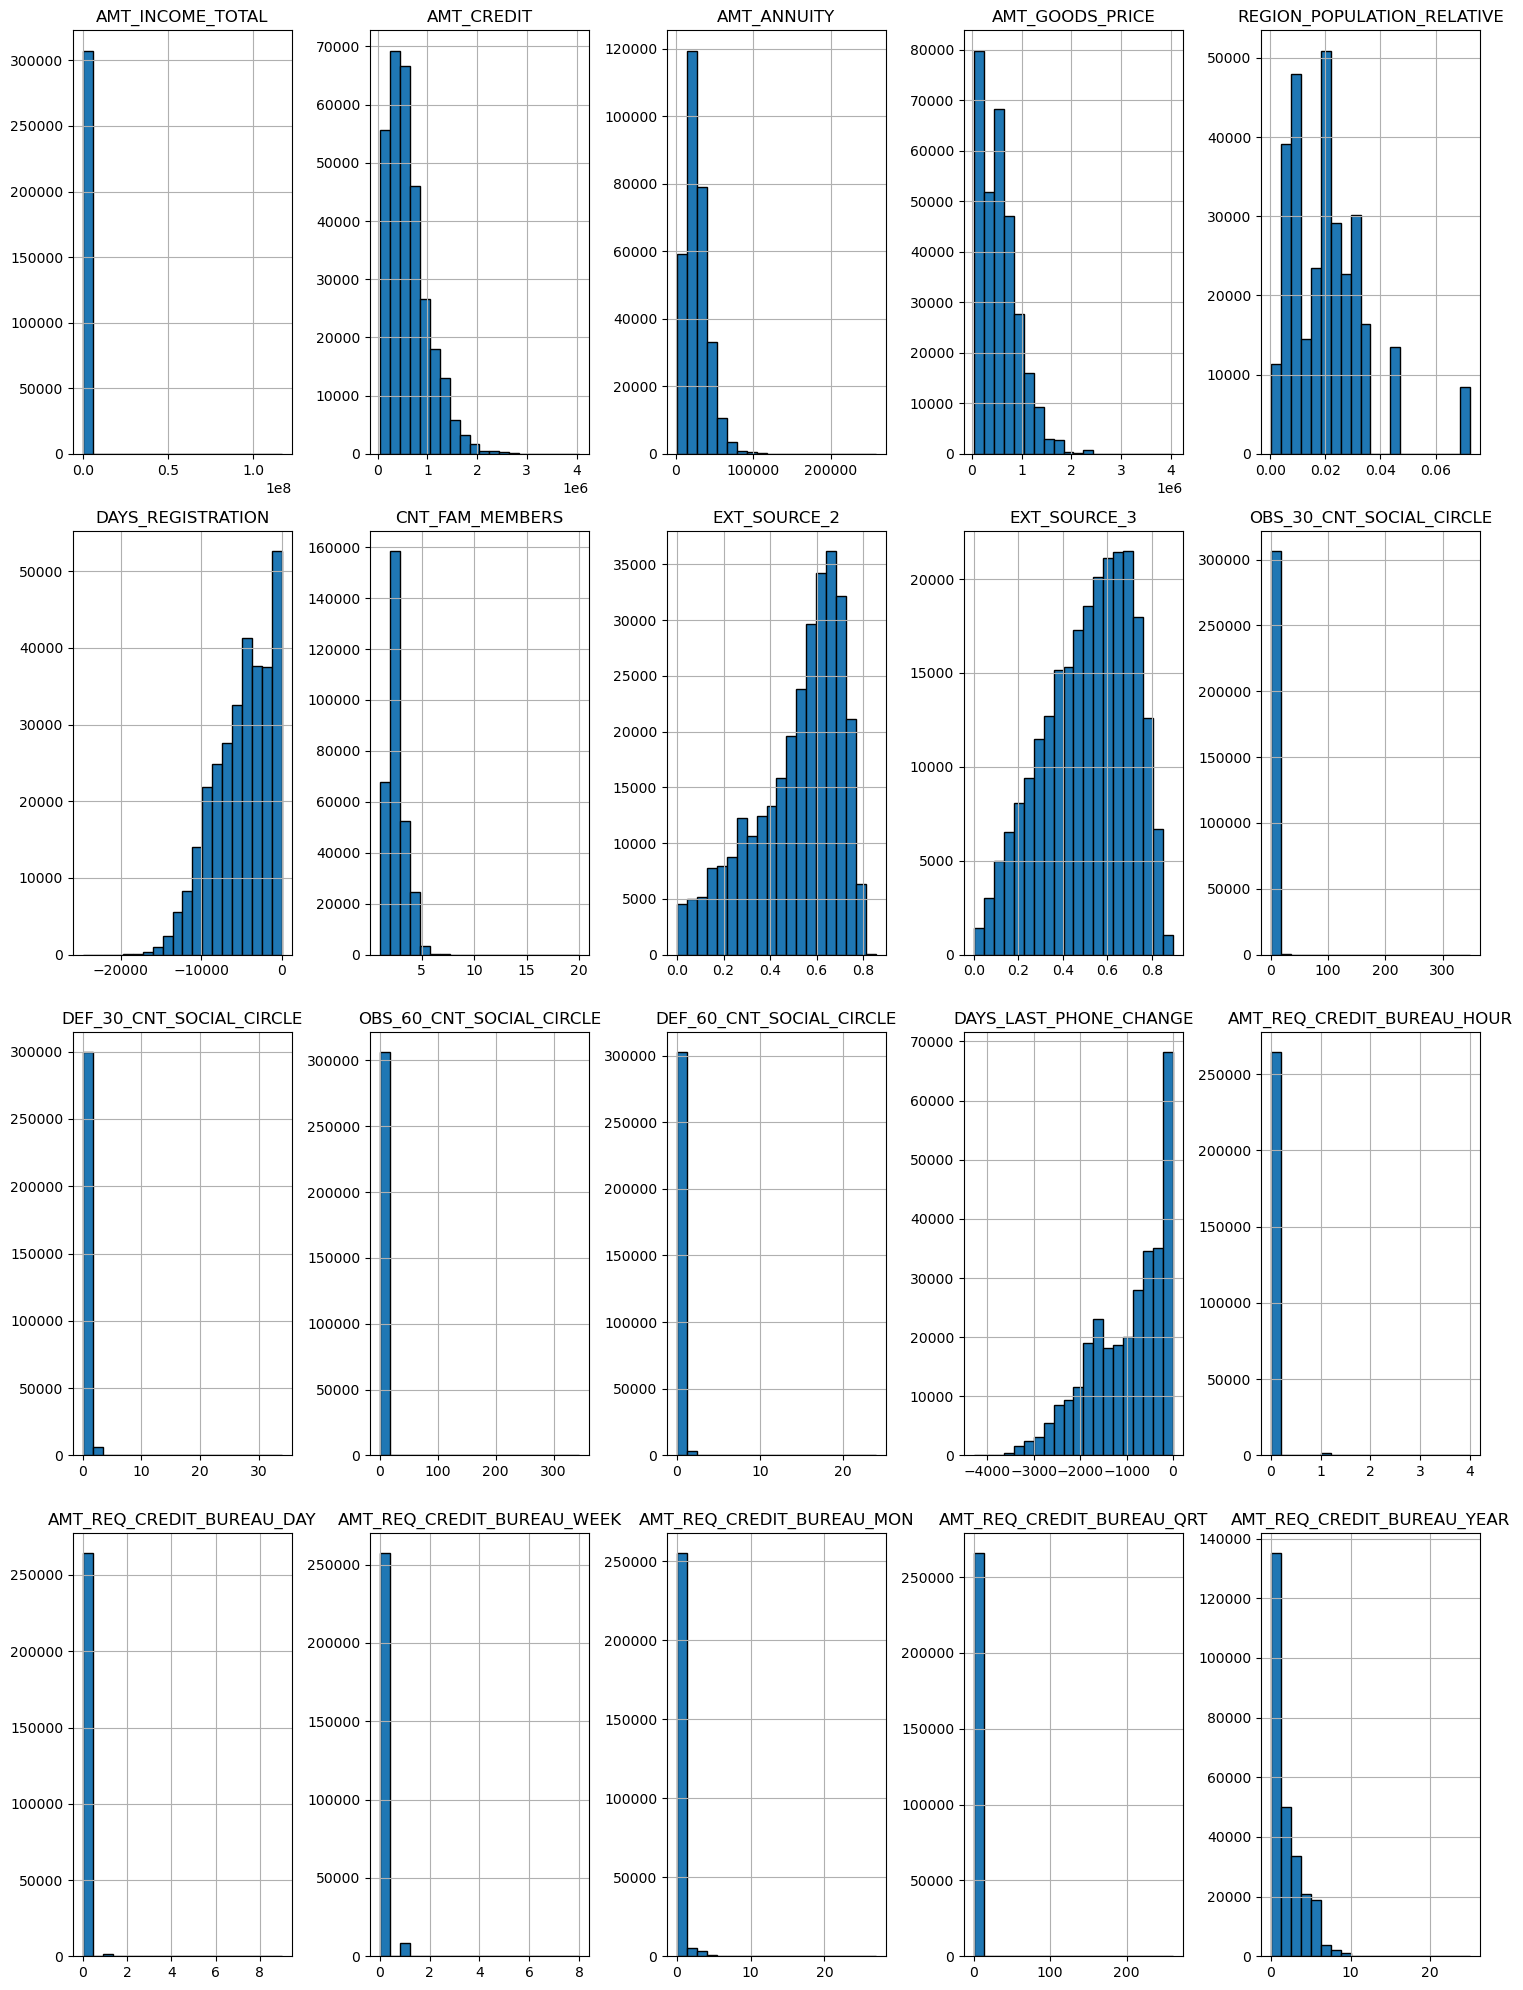

In [38]:
# ploteos de las variables con dtype=float64

df[float_columns].hist(bins=20, figsize=(15, 20), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

### tabla de correlaciones

/var/folders/8z/vjxlhv2s499b46l6s62czlmm0000gn/T/ipykernel_29373/1586622766.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

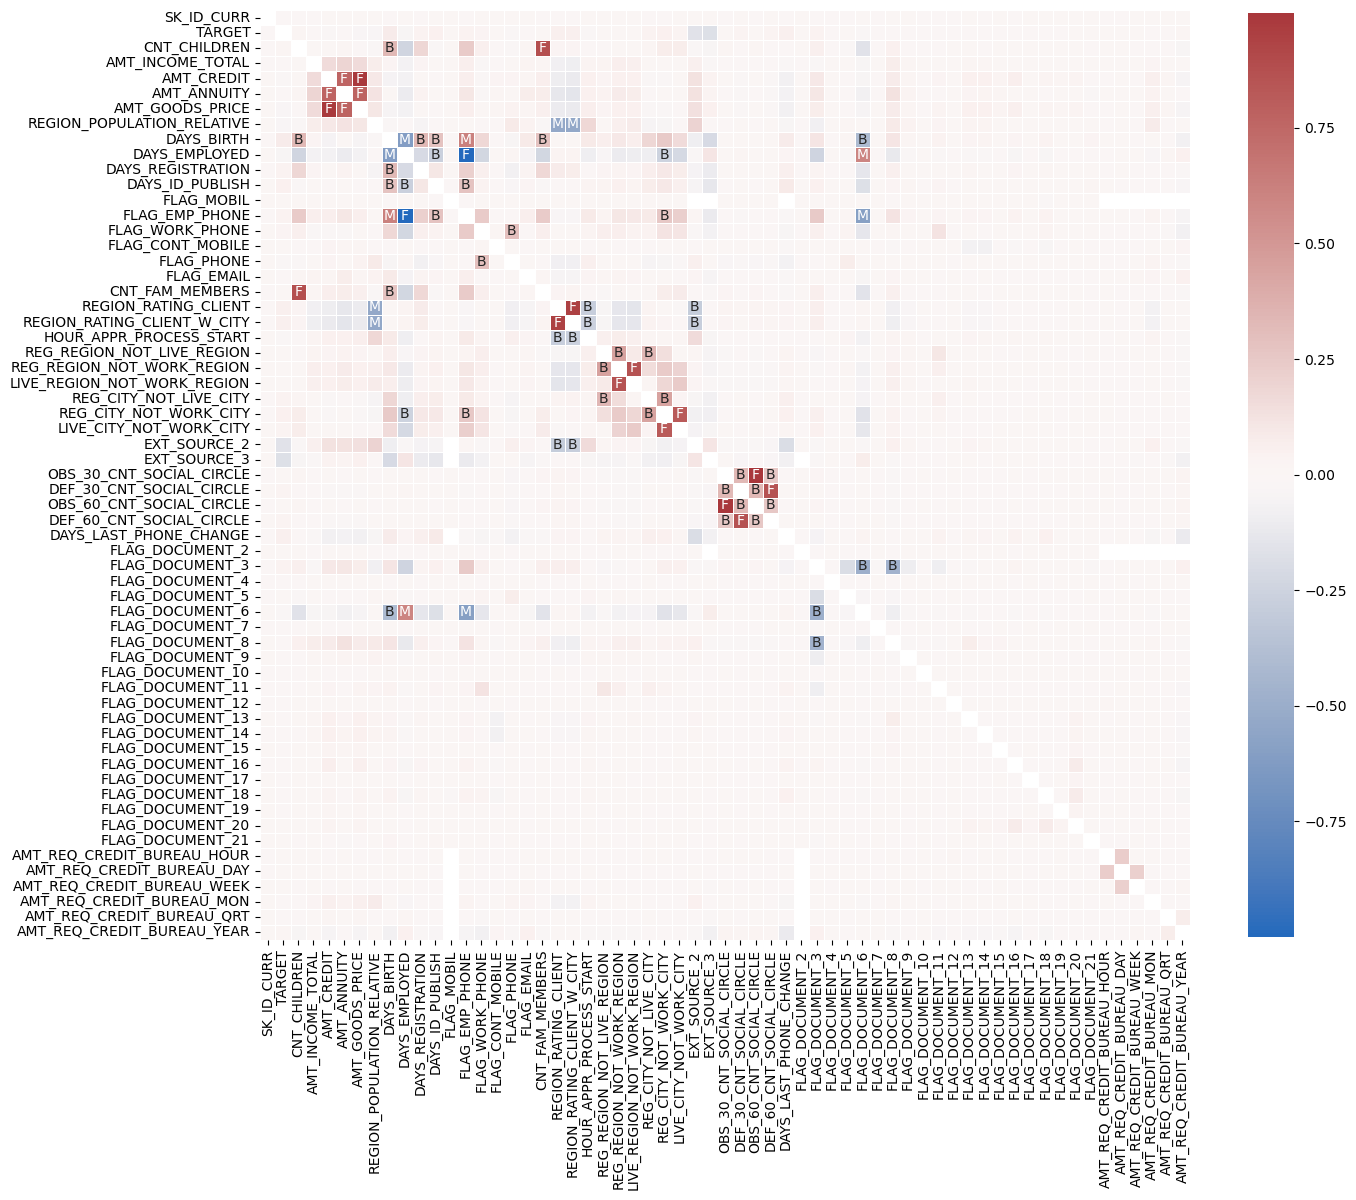

In [39]:
# calculo las correlaciones entre las variables numericas
corr = df.corr()

# creo labels para las correlaciones
labels = np.where(np.abs(corr)>0.75, "F",
                  np.where(np.abs(corr)>0.5, "M",
                  np.where(np.abs(corr)>0.25, "B", "")))

# ploteo correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr, mask=np.eye(len(corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

In [40]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
corr_stacked = corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(corr_stacked)

FLAG_EMP_PHONE               DAYS_EMPLOYED                -0.999755
DAYS_EMPLOYED                DAYS_BIRTH                   -0.615864
FLAG_DOCUMENT_6              FLAG_EMP_PHONE               -0.597732
REGION_RATING_CLIENT         REGION_POPULATION_RELATIVE   -0.532877
REGION_RATING_CLIENT_W_CITY  REGION_POPULATION_RELATIVE   -0.531535
                                                             ...   
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.860627
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.879161
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.950842
AMT_GOODS_PRICE              AMT_CREDIT                    0.986968
OBS_60_CNT_SOCIAL_CIRCLE     OBS_30_CNT_SOCIAL_CIRCLE      0.998490
Length: 1814, dtype: float64

In [41]:
corr_stacked.head(15)

FLAG_EMP_PHONE               DAYS_EMPLOYED                 -0.999755
DAYS_EMPLOYED                DAYS_BIRTH                    -0.615864
FLAG_DOCUMENT_6              FLAG_EMP_PHONE                -0.597732
REGION_RATING_CLIENT         REGION_POPULATION_RELATIVE    -0.532877
REGION_RATING_CLIENT_W_CITY  REGION_POPULATION_RELATIVE    -0.531535
FLAG_DOCUMENT_6              FLAG_DOCUMENT_3               -0.486238
FLAG_DOCUMENT_8              FLAG_DOCUMENT_3               -0.465730
FLAG_DOCUMENT_6              DAYS_BIRTH                    -0.407160
EXT_SOURCE_2                 REGION_RATING_CLIENT          -0.292895
                             REGION_RATING_CLIENT_W_CITY   -0.288299
HOUR_APPR_PROCESS_START      REGION_RATING_CLIENT          -0.285699
DAYS_ID_PUBLISH              DAYS_EMPLOYED                 -0.272378
HOUR_APPR_PROCESS_START      REGION_RATING_CLIENT_W_CITY   -0.264815
REG_CITY_NOT_WORK_CITY       DAYS_EMPLOYED                 -0.254559
FLAG_DOCUMENT_3              DAYS_

In [42]:
corr_stacked.tail(15)

DAYS_REGISTRATION            DAYS_BIRTH                    0.331912
REG_CITY_NOT_LIVE_CITY       REG_REGION_NOT_LIVE_REGION    0.339232
REG_CITY_NOT_WORK_CITY       REG_CITY_NOT_LIVE_CITY        0.440409
REG_REGION_NOT_WORK_REGION   REG_REGION_NOT_LIVE_REGION    0.450804
FLAG_DOCUMENT_6              DAYS_EMPLOYED                 0.597484
FLAG_EMP_PHONE               DAYS_BIRTH                    0.619888
AMT_ANNUITY                  AMT_CREDIT                    0.770138
AMT_GOODS_PRICE              AMT_ANNUITY                   0.775109
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.825575
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.860517
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.860627
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.879161
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.950842
AMT_GOODS_PRICE              AMT_CREDIT                    0.986968
OBS_60_CNT_SOCIAL_CIRCLE     OBS_30_CNT_SOCIAL_C

Estos features tienen una correlacion alta. Se tiene que tener en cuenta que pueden llegar a añadir colinealidad al modelo.

## Conclusiones

- Fue necesario borrar aquellos features que poseían un gran porcentaje de datos faltantes (>20%) porque no había manera de rellenarlos.

- Los features con datos faltantes menores al 20%, se rellenarán con dos métodos diferentes. Aquellos que son numéricos continuos se rellenan con el valor medio, y con la moda en el caso que sean ordinales. Para las variables categóricas se adopta este último método.

- Para la variable categórica ORGANIZATION_TYPE se crean clusters para englobar ciertos valores. Estos fueron generados a mi criterio. Es menester poder utilizar reglas de negocios para esto.

- Hay variables categoricas que pueden convertirse a una escala numerica como WEEKDAY_APPR_PROCESS_START. 

- Existen posibles outliers en diferentes variables como ['DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_QRT','CNT_FAM_MEMBERS','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE']. 

- Variables que voy a descartar por su alta correlación, donde no me van a agregar gran cantidad de información.
['CNT_CHILDREN', 'FLAG_EMP_PHONE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT', '']

# Pre - preparación de datos

In [43]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#Convierto los labels de la variable ORGANIZATION_TYPE.

dict_categories = {'education': ['school','kindergarten', 'university'],
                'business':['business', 'advertising', 'trade'],
                'transport':['transport'],
                'security':['security','police','military'],
                'industry':['industry'],
                'healthcare':['medicine','emergency','insurance', 'cleaning'],
                'services' : ['telecom','mobile','postal', 'electricity', 'services', 'bank'],
                'turism' : ['hotel','restaurant', 'culture'],
                'real-estate' : ['housing', 'realtor', 'construction'], 
                'other' : ['religion', 'other', 'xna']
                }
                
df['ORGANIZATION_TYPE'] = cast_label(dict_categories, df[['ORGANIZATION_TYPE']].copy())

In [92]:
#Convierto los dias de la semana a numerico y los flags a numericos (0,1).

dict_dayweek = {
    'SUNDAY' : 1,
    'MONDAY' : 2,
    'TUESDAY' : 3,
    'WEDNESDAY' : 4,
    'THURSDAY' : 5,
    'FRIDAY' : 6,
    'SUNDAY' : 7
}
dict_Y_N = {'Y' : 1,
            'N' : 0}


df.replace({'WEEKDAY_APPR_PROCESS_START':dict_dayweek, 
            'FLAG_OWN_CAR' : dict_Y_N,
            'FLAG_OWN_REALTY' : dict_Y_N}, inplace=True)

In [117]:

# Elimino los outliers mas significativos

df_wo_outliers = df.drop([df[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 100].index[0], 
                            df[df['OBS_60_CNT_SOCIAL_CIRCLE'] > 100].index[0],
                            df[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 100].index[0],
                            df[df['DEF_60_CNT_SOCIAL_CIRCLE'] > 20].index[0],
                            df[df['DEF_30_CNT_SOCIAL_CIRCLE'] > 20].index[0],], axis=0)

In [131]:
df_wo_outliers.reset_index(drop=True, inplace=True)

In [133]:

# dataset sin variables con alta correlacion

df_wo_hc = df_wo_outliers.drop(columns=['CNT_CHILDREN', 'FLAG_EMP_PHONE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT'])

In [135]:
df_wo_hc.to_csv('preprocessed_application.csv')